# Teledetección como herramienta global. IV Edición.


#### El papel de la Inteligencia Artificial en la Meteorología y el Cambio Climático.

    Javier Díez Sierra -Instituto de Física de Cantabria (IFCA-CSIC)- javier.diez@unican.es

***

> This notebook includes examples of how Artificial Intenligence (AI) can be used in the field of Climate Change. The notebook includes two applications:
> 1) Clusterig: Data mining techniques (non-supervised) are  used to characterize the weather in several synoptic patterns (clusters) to explore the climate.
> 2) Deep Learning: Neural Networks (supervised) are used to increase the spatial resolutions of a Global Climate Model (GCM) and reduce their intrinsic bias.

> Note that the examples are computed at a monthly resolution to reduce computational cost, and therefore, the results are not as expected. Daily resolution is required to obtain good "logical" results during weather typing and Perfect Prognosis. Additionally, seasonality should be extracted from the predictors.

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0) and has been produced by IFCA-CSIC and Predictia for the C3S.

![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)


![TELE_UIMP_2024](portada.png)

## Create a conda environment with all python packages required

##### Load Python Packages

In [1]:
import numpy as np
import cdsapi
import sys
import os
import xarray as xr
import glob
import pandas as pd
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from scipy.interpolate import griddata
from datetime import datetime

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit

##### Some functions to extract zip files

In [3]:
def extract_zip_and_delete(zip_path):
    """
    Function to extract zip files and rename .nc file
    
    Parameters
    ----------
    zip_path (pathlib.Path): path to the downloaded zip files
    """
    with zipfile.ZipFile(zip_path , 'r') as zip_ref:
        names = zip_ref.namelist()
        temporal_files = [
            f"{zip_path.parent}/{name}" for name in names if name.split(".")[-1] == "nc"
        ]
        zip_ref.extractall(zip_path.parent)
        for name in names:
            if name.split(".")[-1] == "nc":
                os.rename(
                    f"{zip_path.parent}/{name}", 
                    zip_path.with_name(zip_path.name.replace('.zip', '.nc'))
                         )
            else:
                os.remove(f"{zip_path.parent}/{name}") 
        os.remove(zip_path)

In [4]:
def fill_nans_with_closest(matrix):
    # Get the indices of the NaNs
    nan_indices = np.argwhere(np.isnan(matrix))

    # Get the indices of the non-NaNs
    non_nan_indices = np.argwhere(~np.isnan(matrix))

    # Get the values of the non-NaNs
    non_nan_values = matrix[~np.isnan(matrix)]

    # Interpolate to fill the NaNs
    filled_matrix = matrix.copy()
    filled_matrix[np.isnan(matrix)] = griddata(non_nan_indices, non_nan_values, nan_indices, method='nearest')
    
    return filled_matrix

In [401]:
def getMontlyMetrics(data, to_slice = None):
    if to_slice != None:
        data = data.sel(time=slice(*to_slice))
    data = data.groupby(data.index.month)
    mean = data.mean()
    std = data.std()
    return {'mean': mean, 'std': std}
def __operationStandarBias(data, mean, std):
    result = (data - mean)/std
    return result
def __operationStandarDeBias(data, mean, std):
    result = (data*std) + mean
    return result
def standarBiasCorrection(data, mean, std):
    data_corrected = data*np.nan
    for mes in range(1, 13):
        data_corrected[data.index.month == mes] = __operationStandarBias(
            data[data.index.month == mes], mean.loc[mes], std.loc[mes])
    return data_corrected
def standarDeBiasCorrection(data, mean, std):
    data_corrected = data*np.nan
    for mes in range(1, 13):
        data_corrected[data.index.month == mes] = __operationStandarDeBias(
            data[data.index.month == mes], mean.loc[mes], std.loc[mes])
    return data_corrected

## Dowload climate data with the CDS API
- How to use the CDS API: [https://cds.climate.copernicus.eu/api-how-to](https://cds.climate.copernicus.eu/api-how-to)

##### Attributes to download and save the data

In [5]:
dest = './data/'

In [6]:
years_historical = [str(y) for y in np.arange(1970, 2015)]
pressure_levels = ['500', '850']

In [7]:
c = cdsapi.Client()

##### Download ERA5 data

ERA5 monthly data on pressure levels: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means?tab=overview

In [ ]:
for year in years_historical:
    for level in pressure_levels:
        dest2save = f"{dest}{'era5'}/z{level}/"
        os.makedirs(dest2save, exist_ok=True)
        c.retrieve(
            'reanalysis-era5-pressure-levels-monthly-means',
            {
                'format': 'netcdf',
                'product_type': 'monthly_averaged_reanalysis',
                'variable': 'geopotential',
                'pressure_level': level,
                'year': year,
                'month': [
                    '01', '02', '03',
                    '04', '05', '06',
                    '07', '08', '09',
                    '10', '11', '12',
                ],
                'area': [
                    68.5, -39, 23.5,
                    22.5,
                ],
                'time': '00:00',
            },
            f"{dest2save}/z{level}_{year}.nc")

ERA5 monthly data on single levels: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means?tab=overview

In [ ]:
for year in years_historical:
    dest2save = f"{dest}{'era5'}/msl/"
    os.makedirs(dest2save, exist_ok=True)
    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'product_type': 'monthly_averaged_reanalysis',
            'variable': 'mean_sea_level_pressure',
            'year': year,
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'area': [
                68.5, -39, 23.5,
                22.5,
            ],
            'time': '00:00',
            'format': 'netcdf',
        },
        f"{dest2save}/msl_{year}.nc")

##### Download gridded observational data from E-OBS dataset

E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations: https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-gridded-observations-europe?tab=overview

In [ ]:
dest2save = f"{dest}{'E-OBS'}/pr/"
os.makedirs(dest2save, exist_ok=True)
path_zip = Path(f"{dest2save}/pr_1950-2023.zip")
c.retrieve(
    'insitu-gridded-observations-europe',
    {
        'format': 'zip',
        'product_type': 'ensemble_mean',
        'variable': 'precipitation_amount',
        'grid_resolution': '0.1deg',
        'period': 'full_period',
        'version': '29.0e',
    },
    path_zip)
extract_zip_and_delete(path_zip)

#### Download CMIP6 future proyection for [access_cm2](https://research.csiro.au/access/about/cm2/) model

CMIP6 climate projections: https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview

In [ ]:
scenarios = {
    "ssp5_8_5": np.arange(2016, 2101),
    "historical" : years_historical}
variables = {"precipitation": "pr",
             "sea_level_pressure": "msl"}

In [ ]:
for scenario in scenarios.keys(): 
    years_sce = scenarios[scenario]
    for level in pressure_levels:
        for year in years_sce:
            dest2save = f"{dest}{'CMIP6'}/z{level}"
            os.makedirs(dest2save, exist_ok=True)
            path_zip = Path(f"{dest2save}/z{level}_{scenario}_{year}.zip")
            c.retrieve(
            'projections-cmip6',
            {
                'format': 'zip',
                'temporal_resolution': 'monthly',
                'experiment': scenario,
                'variable': 'geopotential_height',
                'level': level,
                'model': 'access_cm2',
                'year': str(year),
                'month': [
                    '01', '02', '03',
                    '04', '05', '06',
                    '07', '08', '09',
                    '10', '11', '12',
                ],
                'area': [
                    68.5, -39, 23.5,
                    22.5,
                ],
            },
            path_zip)
            extract_zip_and_delete(path_zip)

In [ ]:
for scenario in scenarios.keys(): 
    years_sce = scenarios[scenario]
    for variable in variables.keys():
        var_short = variables[variable]
        for year in years_sce:
            dest2save = f"{dest}{'CMIP6'}/{var_short}"
            os.makedirs(dest2save, exist_ok=True)
            path_zip = Path(f"{dest2save}/{var_short}_{scenario}_{year}.zip")
            c.retrieve(
            'projections-cmip6',
            {
                'format': 'zip',
                'temporal_resolution': 'monthly',
                'experiment': scenario,
                'variable': variable,
                'model': 'access_cm2',
                'year': str(year),
                'month': [
                    '01', '02', '03',
                    '04', '05', '06',
                    '07', '08', '09',
                    '10', '11', '12',
                ],
                'area': [
                    68.5, -39, 23.5,
                    22.5,
                ],
            },
            path_zip)
            extract_zip_and_delete(path_zip)

## Preprocessing data

##### Remapping ERA5 data to a coarse resoltuion to reduce the computational cost

In [ ]:
new_resolution = {'lat': 2, 'lon': 2}

In [ ]:
# Define grid
lon_grid = np.arange(-36, 20, new_resolution['lon'])
lat_grid = np.arange(26, 66, new_resolution['lat'])

# Convert to xarray DataArray
lon_grid_da = xr.DataArray(lon_grid, dims=['lon'])
lat_grid_da = xr.DataArray(lat_grid, dims=['lat'])

In [ ]:
for var in ['z500', 'z850', 'msl']:
    files = np.sort(glob.glob(f"{dest}era5/{var}/*.nc"))
    ds = xr.open_mfdataset(files, concat_dim = 'time', combine = 'nested').chunk(dict(time=-1))
    ds_remap = ds.interp(longitude=lon_grid_da, latitude=lat_grid_da, method="linear")
    # Renaming the variable    
    if var in ['z500', 'z850']:
        ds_remap = ds_remap.rename({'z': var})
     # Linear interpolation along the time dimension to remove NaNs       
    ds_remap[var][:] = ds_remap[var].interpolate_na(dim='time', method='linear')
    ds_remap.to_netcdf(f"{dest}/ERA5_{var}_mon_2x2_{years_historical[0]}-{years_historical[-1]}.nc")

##### Crop E-OBS datasets across the Iberian Peninsula and resample to monthly data

In [ ]:
lon_lim = slice(-9.5, 3.5)
lat_lim = slice(35.5, 44.5)

In [ ]:
EOBS_pr = xr.open_dataset(f"{dest}E-OBS/pr/pr_1950-2023.nc")

In [ ]:
EOBS_pr['rr'].isel(time = 0).plot()

In [ ]:
EOBS_pr_mon = EOBS_pr.resample(time = 'MS').sum()
EOBS_pr_mon_spain = EOBS_pr_mon.sel(longitude = lon_lim, 
                                    latitude = lat_lim)
# Renaming the variable
EOBS_pr_mon_spain = EOBS_pr_mon_spain.rename({'rr': 'pr'})
EOBS_pr_mon_spain.to_netcdf(f"{dest}/E-OBS_pr_mon_spain_1950-2023.nc")

In [ ]:
EOBS_pr_mon_spain['pr'].isel(time = 0).plot()

##### Remapping CMIP6 data to ERA5 resolution

In [ ]:
for var in ['z500', 'z850', 'pr', 'msl']:
    files = np.sort(glob.glob(f"{dest}CMIP6/{var}/*.nc"))
    ds = xr.open_mfdataset(files, concat_dim = 'time', combine = 'nested').chunk(dict(time=-1))
    ds_remap = ds.interp(lon=lon_grid_da, lat=lat_grid_da, method="linear")

    # Renaming the variable    
    if var in ['z500', 'z850']:
        ds_remap = ds_remap.rename({'zg': var})
    if var == 'msl':
        ds_remap = ds_remap.rename({'psl': var})        
     # Linear interpolation along the time dimension to remove NaNs       
    ds_remap[var][:] = ds_remap[var].interpolate_na(dim='time', method='linear')
    ds_remap.to_netcdf(f"{dest}/CMIP6_{var}_mon_2x2_hist_ssp585_{years_historical[0]}-2100.nc")

## Load preprocessed data

##### ERA5

In [82]:
ERA5_msl = xr.open_dataset(f"{dest}/ERA5_msl_mon_2x2_1970-2014.nc")
ERA5_z850 = xr.open_dataset(f"{dest}/ERA5_z850_mon_2x2_1970-2014.nc")
ERA5_z500 = xr.open_dataset(f"{dest}/ERA5_z500_mon_2x2_1970-2014.nc")

##### E-OBS

In [83]:
EOBS_pr = xr.open_dataset(f"{dest}/E-OBS_pr_mon_spain_1950-2023.nc")

##### CMIP6

In [84]:
CMIP6_msl = xr.open_dataset(f"{dest}/CMIP6_msl_mon_2x2_hist_ssp585_1970-2100.nc")
CMIP6_z850 = xr.open_dataset(f"{dest}/CMIP6_z850_mon_2x2_hist_ssp585_1970-2100.nc")
CMIP6_z500 = xr.open_dataset(f"{dest}/CMIP6_z500_mon_2x2_hist_ssp585_1970-2100.nc")
CMIP6_pr = xr.open_dataset(f"{dest}/CMIP6_pr_mon_2x2_hist_ssp585_1970-2100.nc")

## Clustering

### Prepare data for k-means

In [422]:
ERA5_msl_flat = (ERA5_msl['msl'].stack(points=('lat', 'lon'))).values
ERA5_z850_flat = (ERA5_z850['z850'].stack(points=('lat', 'lon'))).values
ERA5_z500_flat = (ERA5_z500['z500'].stack(points=('lat', 'lon'))).values

In [423]:
X_ERA5 = np.hstack([ERA5_msl_flat, ERA5_z850_flat/9.80665, ERA5_z500_flat/9.80665])
X_ERA5 = fill_nans_with_closest(X_ERA5)

scaler = StandardScaler()
X_ERA5_scaled = scaler.fit_transform(X_ERA5)

### Elbow method to find optimal k

https://jwcn-eurasipjournals.springeropen.com/articles/10.1186/s13638-021-01910-w

In [426]:
nc = 20
inertia = []
for k in range(1, nc):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_ERA5_scaled)
    inertia.append(kmeans.inertia_)

/home/javi/mambaforge/envs/teledetect/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/javi/mambaforge/envs/teledetect/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/javi/mambaforge/envs/teledetect/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/javi/mambaforge/envs/teledetect/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: Fut

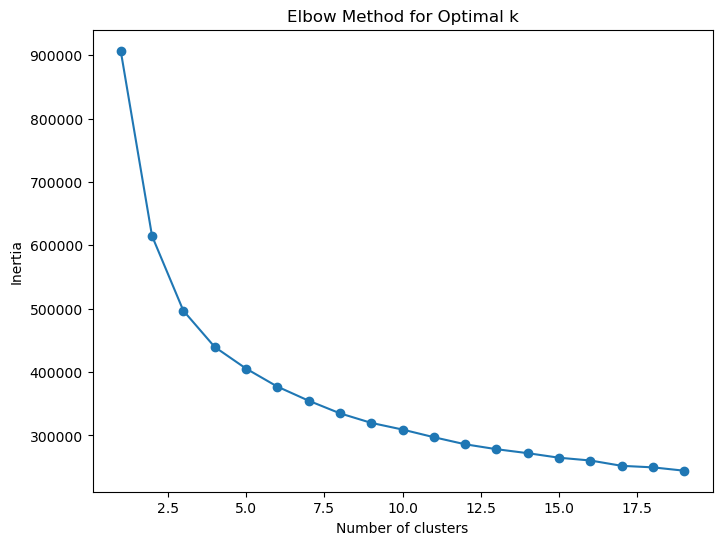

In [427]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, nc), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

### Fit k-means

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [428]:
n_cluster = 12
n_predictors = 3
# Example: Training k-means with chosen number of clusters
kmeans = KMeans(n_clusters=n_cluster, random_state=42)
kmeans.fit(X_ERA5_scaled)

/home/javi/mambaforge/envs/teledetect/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=12, random_state=42)

In [429]:
# Example: Add cluster labels back to your original DataFrame
labels = kmeans.labels_
# Example: Analyze the cluster centers (centroid) to understand each cluster's characteristics
cluster_centers = kmeans.cluster_centers_
# Desescalar los centroides para interpretación
cluster_centers_unscaled = scaler.inverse_transform(cluster_centers)

### Apply PCA to see the results

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

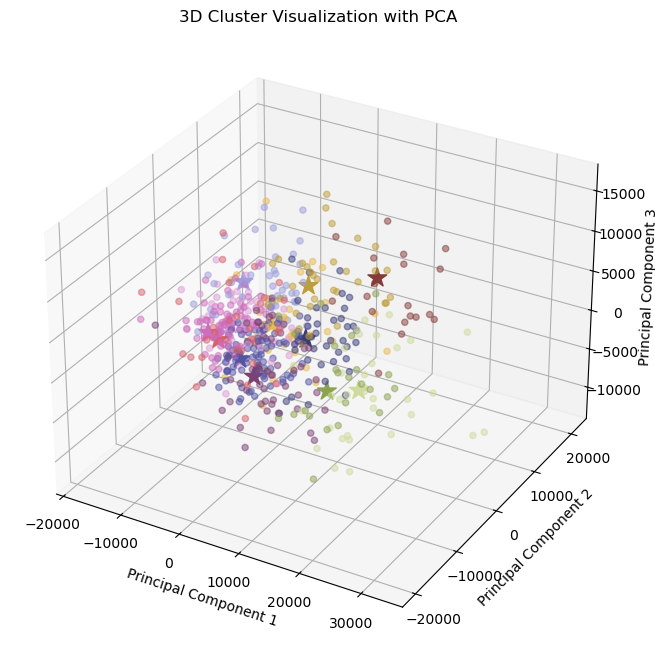

In [430]:
# Apply PCA to reduce to 3 dimensions
pca_3d = PCA(n_components=3)
reduced_data_3d = pca_3d.fit_transform(X_ERA5)
df_3d = pd.DataFrame(reduced_data_3d, columns=['PC1', 'PC2', 'PC3'])
df_3d['cluster'] = labels

pca_3d_c = PCA(n_components=3)
reduced_data_3d_c = pca_3d_c.fit_transform(cluster_centers_unscaled)
df_3d_c = pd.DataFrame(reduced_data_3d_c, columns=['PC1', 'PC2', 'PC3'])
df_3d_c['cluster'] = np.arange(n_cluster)

# Plot the clusters in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_3d['PC1'], df_3d['PC2'], df_3d['PC3'], c=df_3d['cluster'], 
                cmap='tab20b', s=20, alpha=0.5, zorder = 1)
sc_ = ax.scatter(df_3d_c['PC1'], df_3d_c['PC2'], df_3d_c['PC3'], c=df_3d_c['cluster'], 
                 cmap='tab20b', s=200, marker = '*', alpha=1, zorder = 10)

plt.title('3D Cluster Visualization with PCA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
#plt.colorbar(sc, label='Cluster')
plt.show()

### Plotting weather types

In [431]:
n_lon = len(ERA5_msl.longitude)
n_lat = len(ERA5_msl.latitude)
n_cells = n_lat*n_lon

/tmp/ipykernel_480792/891813832.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.04, 0.1, 1, 1])  # Adjust layout to make room for colorbars


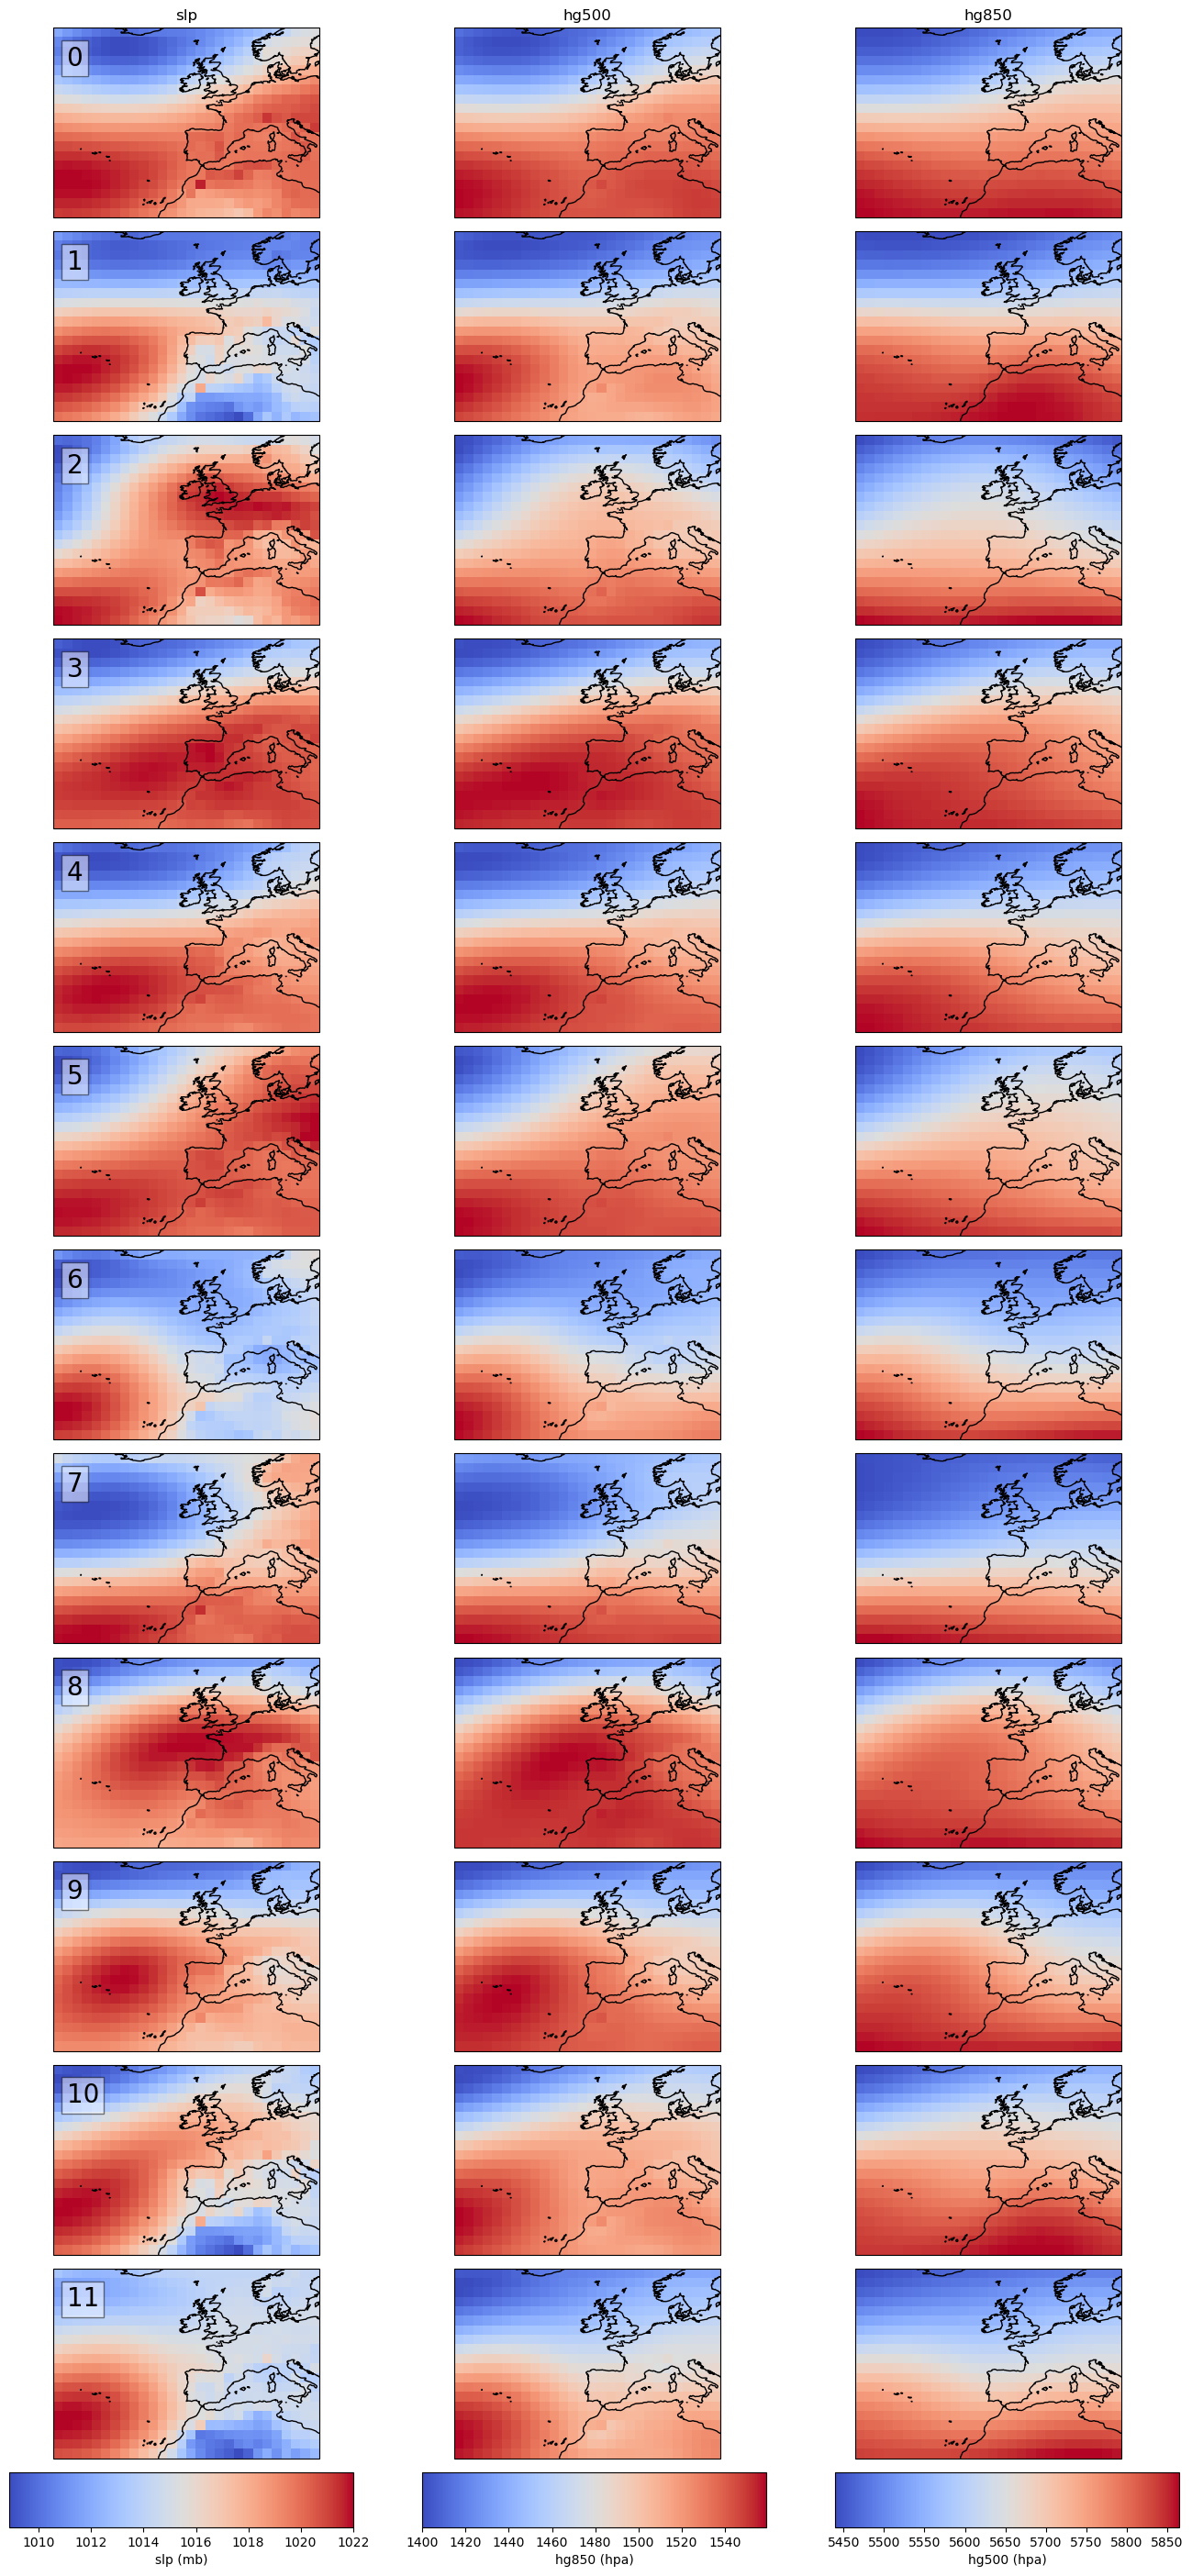

In [432]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=n_cluster, ncols=n_predictors, 
                       subplot_kw={'projection': proj}, figsize=(15, 30))

for r in range(n_cluster):
    # slp
    predictor_msl = cluster_centers_unscaled[r, 0*n_cells:1*n_cells].reshape(n_lat, n_lon)/100 
    mesh1 = ax[r, 0].pcolormesh(ERA5_msl.longitude, ERA5_msl.latitude, predictor_msl, cmap = 'coolwarm')
    ax[r, 0].annotate(f"{r}", (0.05, 0.8), xycoords='axes fraction', fontsize = 20,
                     bbox=dict(facecolor='w', alpha=0.5),)
    ax[r, 0].coastlines()

    # hg850
    predictor_z850 = cluster_centers_unscaled[r, 1*n_cells:2*n_cells].reshape(n_lat, n_lon) 
    mesh2 = ax[r, 1].pcolormesh(ERA5_z850.longitude, ERA5_z850.latitude, predictor_z850, cmap = 'coolwarm')
    ax[r, 1].coastlines()

    # hg500
    predictor_z500 = cluster_centers_unscaled[r, 2*n_cells:3*n_cells].reshape(n_lat, n_lon) 
    mesh3 = ax[r, 2].pcolormesh(ERA5_z500.longitude, ERA5_z500.latitude, predictor_z500, cmap = 'coolwarm')
    ax[r, 2].coastlines()

ax[0, 0].set_title('slp')
ax[0, 1].set_title('hg500')
ax[0, 2].set_title('hg850')

# Add colorbars for each column
cbar_ax1 = fig.add_axes([0.1, 0.08, 0.25, 0.02])  # [left, bottom, width, height] for the first column
cbar_ax2 = fig.add_axes([0.4, 0.08, 0.25, 0.02])  # [left, bottom, width, height] for the second column
cbar_ax3 = fig.add_axes([0.7, 0.08, 0.25, 0.02])  # [left, bottom, width, height] for the third column

cbar1 = fig.colorbar(mesh1, cax=cbar_ax1, orientation='horizontal')
cbar2 = fig.colorbar(mesh2, cax=cbar_ax2, orientation='horizontal')
cbar3 = fig.colorbar(mesh3, cax=cbar_ax3, orientation='horizontal')

cbar1.set_label('slp (mb)')
cbar2.set_label('hg850 (hpa)')
cbar3.set_label('hg500 (hpa)')

plt.tight_layout(rect=[0.04, 0.1, 1, 1])  # Adjust layout to make room for colorbars

#fig.subplots_adjust(wspace=0.00001, hspace=0.1) 

### Plotting cluster frequency

In [433]:
df_labels = pd.DataFrame(index = ERA5_msl.time)
df_labels['cluster'] = labels

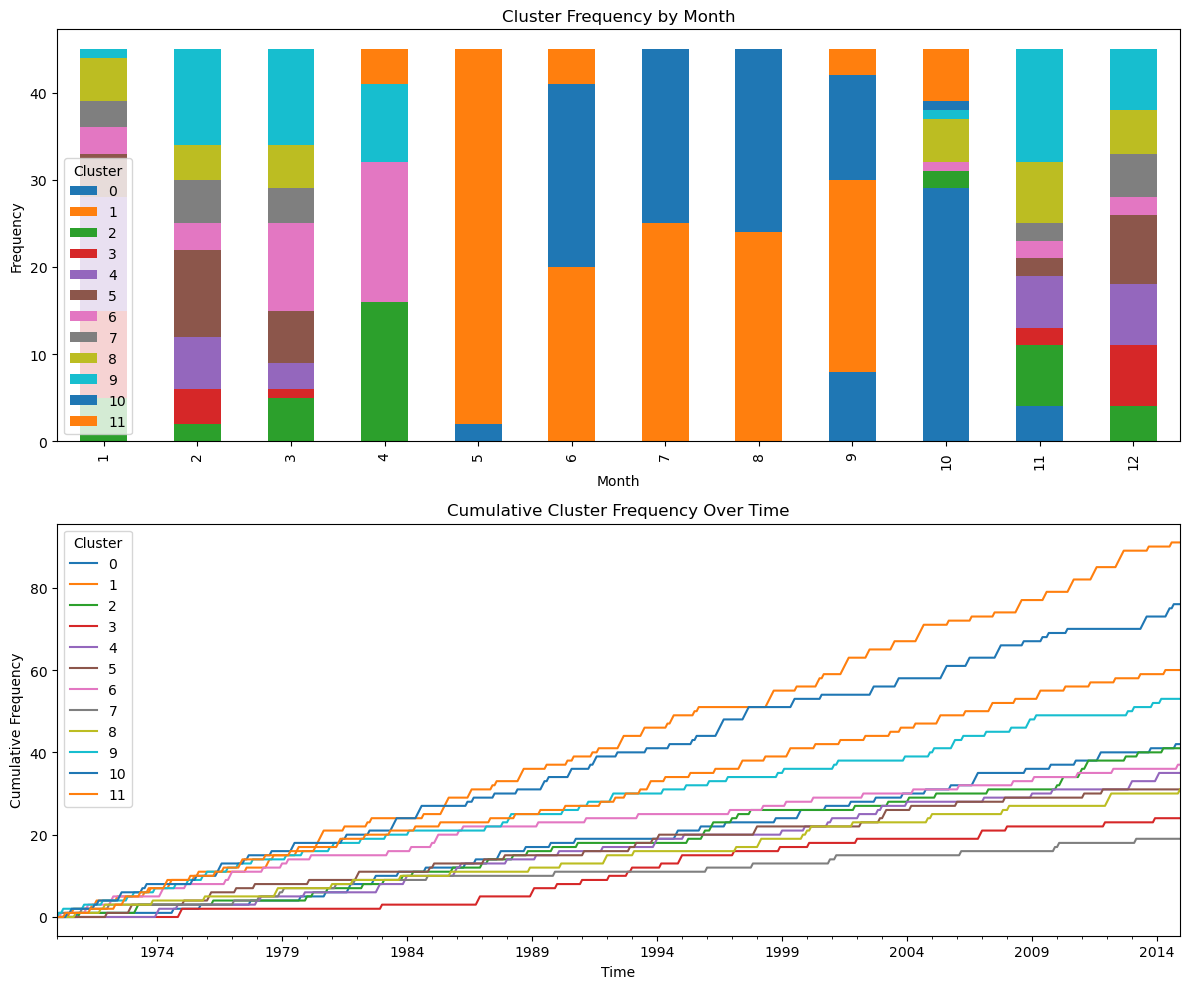

In [434]:
df = df_labels

# Plot frequency of clusters over time
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

# Calculate frequency of each cluster by month
df['month'] = df.index.month
cluster_counts_by_month = df.groupby(['month', 'cluster']).size().unstack(fill_value=0)

# Plot as stacked bar chart
cluster_counts_by_month.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_title('Cluster Frequency by Month')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Frequency')
axs[0].legend(title='Cluster')

# Calculate overall frequency of clusters over time
cluster_counts_over_time = df.groupby(df.index).cluster.value_counts().unstack(fill_value=0).cumsum()

# Plot as line chart
cluster_counts_over_time.plot(ax=axs[1])
axs[1].set_title('Cumulative Cluster Frequency Over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Cumulative Frequency')
axs[1].legend(title='Cluster')
#pr_s['pr'].resample(time = 'YS').sum().plot(ax = axs[1])

plt.tight_layout()
plt.show()

### Compare observed precipitation with weather types

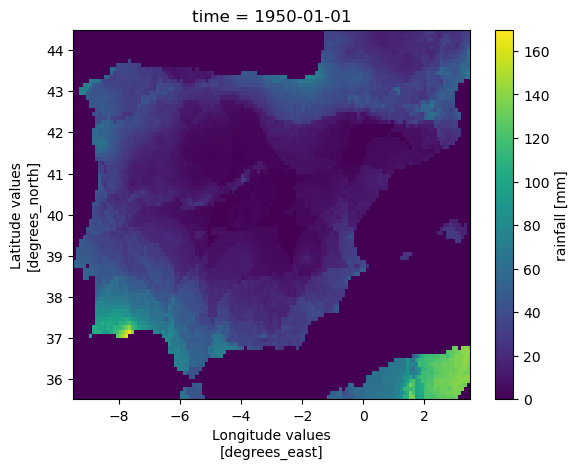

In [435]:
EOBS_pr['pr'].isel(time = 0).plot()

In [436]:
# select pr for Santander
pr_city = EOBS_pr.sel(longitude = -3.805000, latitude = 43.462776, method = 'nearest')
# select pr for Cadiz
#pr_city = gpp_pr.sel(lon = -6.2805, lat = 36.5210, method = 'nearest')

In [437]:
# Get the time range from ERA%
time_min = ERA5_msl.time.min().values
time_max = ERA5_msl.time.max().values
# Crop the first dataset using the time range of the second dataset
pr_city = pr_city.sel(time=slice(time_min, time_max))

In [438]:
df_cluster_pr = pd.DataFrame(index = ERA5_msl.time.values)
df_cluster_pr['pr'] = pr_city['pr'].values

In [439]:
df_cluster_pr['cluster'] = labels

In [442]:
df_cluster_pr_gp_sum = df_cluster_pr.groupby(['cluster'])['pr'].sum().reset_index()
df_cluster_pr_gp_mean = df_cluster_pr.groupby(['cluster'])['pr'].mean().reset_index()
df_cluster_pr_gp = pd.DataFrame()
df_cluster_pr_gp['cluster'] = df_cluster_pr_gp_mean['cluster']
df_cluster_pr_gp['sum'] = df_cluster_pr_gp_sum['pr']
df_cluster_pr_gp['mean'] = df_cluster_pr_gp_mean['pr']

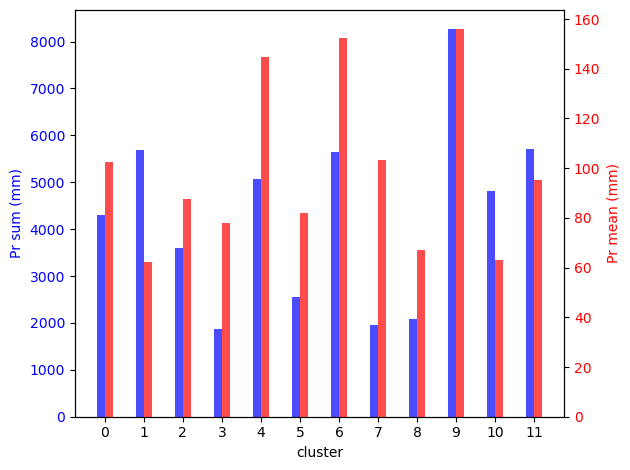

In [443]:
# Plotting
fig, ax1 = plt.subplots()

# Bar plot for A
ax1.bar(df_cluster_pr_gp['cluster'] - 0.1, df_cluster_pr_gp['sum'], 
        color='b', alpha=0.7, label='sum', width=0.2)

ax1.set_xlabel('cluster')
ax1.set_ylabel('Pr sum (mm)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a secondary y-axis for B
ax2 = ax1.twinx()
ax2.bar(df_cluster_pr_gp['cluster'] + 0.1, df_cluster_pr_gp['mean'],
        color='r', alpha=0.7, label='mean', width=0.2)
ax2.set_ylabel('Pr mean (mm)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Adjust layout
fig.tight_layout()

ax2.set_xticks(np.linspace(0, 11, 12))
ax2.set_xticklabels([str(int(n)) for n in np.linspace(0, 11, 12)])

# Show plot
plt.show()

## Deep Learning

### Fit neural network model for one location
See Convolutional Neural Network to adjust the entire Iberian Peninsula and conserve the spatial features (correlation): https://link.springer.com/article/10.1007/s00382-021-05847-0

In [446]:
#Example data (replace with your actual data)
X_train, X_test, y_train, y_test = train_test_split(X_ERA5_scaled, pr_city['pr'].values, 
                                                    test_size=0.2, random_state=42)

# Define the MLPRegressor with SGD and early stopping
mlp = MLPRegressor(hidden_layer_sizes=(20, 20, 20),
                   activation='relu',
                   solver='adam',  # SGD is specified by 'adam' solver in MLPRegressor
                   alpha=0.0001, # Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
                   batch_size='auto', # Size of minibatches for stochastic optimizers
                   learning_rate='constant',
                   learning_rate_init=0.001,
                   max_iter=1000,
                   shuffle=True,
                   random_state=42,
                   tol=1e-4,
                   verbose=True,
                   early_stopping=True,  # Enable early stopping
                   n_iter_no_change=10,   # Number of iterations with no improvement to wait before stopping
                   validation_fraction=0.2)  # Fraction of training data to use as validation set

#Output Layer: For regression tasks (like MLPRegressor), 
#scikit-learn always uses a linear activation function 
#(i.e., no activation function) in the output layer. 
#This is because the output of the regression model is 
#typically a continuous value, and a linear activation 
#function directly provides this output without any transformation.

# Example fitting (replace with your actual data)
mlp.fit(X_train, y_train)

# Once fitted, you can use the model to predict
y_pred = mlp.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Iteration 1, loss = 6718.48119953
Validation score: -2.041535
Iteration 2, loss = 6625.70072091
Validation score: -1.991671
Iteration 3, loss = 6510.97235397
Validation score: -1.938802
Iteration 4, loss = 6382.30731502
Validation score: -1.878203
Iteration 5, loss = 6234.22802962
Validation score: -1.811149
Iteration 6, loss = 6076.30875899
Validation score: -1.737857
Iteration 7, loss = 5899.79725987
Validation score: -1.657464
Iteration 8, loss = 5704.91898374
Validation score: -1.569320
Iteration 9, loss = 5499.77612999
Validation score: -1.474819
Iteration 10, loss = 5288.66153293
Validation score: -1.374005
Iteration 11, loss = 5049.70249242
Validation score: -1.267318
Iteration 12, loss = 4816.06530716
Validation score: -1.154303
Iteration 13, loss = 4574.07785447
Validation score: -1.036392
Iteration 14, loss = 4321.23578226
Validation score: -0.916667
Iteration 15, loss = 4068.83815219
Validation score: -0.796620
Iteration 16, loss = 3836.25089213
Validation score: -0.677926
I

Text(0.5, 0, 'obs (mm/month)')

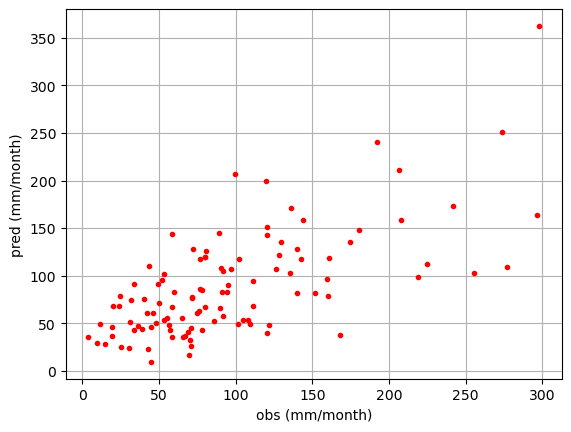

In [447]:
plt.plot(y_test, y_pred, '.r')
plt.grid(True)
plt.ylabel('pred (mm/month)')
plt.xlabel('obs (mm/month)')

## Statistical downscaling using Perfect Prognosis

In [448]:
EOBS_pr = xr.open_dataset(f"{dest}/E-OBS_pr_mon_spain_1950-2023.nc")

In [449]:
# select pr for Santander
pr_city = EOBS_pr.sel(longitude = -3.805000, latitude = 43.462776, method = 'nearest')

In [450]:
# Get the time range from ERA%
time_min = CMIP6_msl.time.min().values
time_max = CMIP6_msl.time.max().values
# Crop the first dataset using the time range of the second dataset
pr_city = pr_city.sel(time=slice(time_min, time_max))

In [451]:
CMIP6_msl_flat = (CMIP6_msl['msl'].stack(points=('lat', 'lon'))).values
CMIP6_z850_flat = (CMIP6_z850['z850'].isel(plev = 0).stack(points=('lat', 'lon'))).values
CMIP6_z500_flat = (CMIP6_z500['z500'].isel(plev = 0).stack(points=('lat', 'lon'))).values

In [452]:
X_CMIP6 = np.hstack([CMIP6_msl_flat, CMIP6_z850_flat, CMIP6_z500_flat])

In [453]:
X_CMIP6 = fill_nans_with_closest(X_CMIP6)

In [454]:
X_CMIP6_scaled = scaler.transform(X_CMIP6)
#scaler = StandardScaler()
#X_CMIP6_scaled = scaler.fit_transform(X_CMIP6)
#X_CMIP6_scaled = (X_CMIP6 - X_ERA5_mean)/X_ERA5_var

In [455]:
# Once fitted, you can use the model to predict
y_pred_CMIP6 = mlp.predict(X_CMIP6_scaled)

In [456]:
CMIP6_time = pd.to_datetime([(f"{t.dt.year.values}-{t.dt.month.values}") for t in CMIP6_msl.time])
EOBS_time = pd.to_datetime([f"{t.dt.year.values}-{t.dt.month.values}" for t in pr_city.time])
CMIP6_EOBS_int = np.where(np.in1d(EOBS_time, CMIP6_time))[0]

In [457]:
CMIP6_city = pd.DataFrame(index = CMIP6_time)
CMIP6_city['pr_raw'] = CMIP6_pr['pr'].sel(lon = -3.805000, lat = 43.462776, method = 'nearest').values*86400*30
CMIP6_city['pr_downscaled_PP'] = y_pred_CMIP6
CMIP6_city['pr_EOBS'] = np.nan
CMIP6_city['pr_EOBS'][CMIP6_EOBS_int] = pr_city['pr'].isel(time = CMIP6_EOBS_int).values

/tmp/ipykernel_480792/1140097648.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  CMIP6_city['pr_EOBS'][CMIP6_EOBS_int] = pr_city['pr'].isel(time = CMIP6_EOBS_int).values
/tmp/ipykernel_480792/1140097648.py:5: SettingWithCopyWarning: 
A v

/tmp/ipykernel_480792/1866077589.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  CMIP6_city.resample('Y').mean().plot()


Text(0, 0.5, 'mm/year')

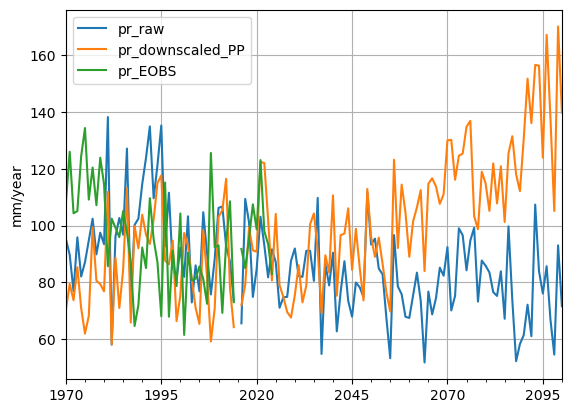

In [458]:
CMIP6_city.resample('Y').mean().plot()
plt.grid(True)
plt.ylabel('mm/year')

In [459]:
CMIP6_city_dropna_rows = CMIP6_city.dropna()

In [460]:
CMIP6_city_dropna_rows

,pr_raw,pr_downscaled_PP,pr_EOBS
1970-01-01,76.076090,80.403625,120.099998
1970-02-01,18.350430,7.650562,119.700005
1970-03-01,74.644652,10.549737,193.300003
1970-04-01,171.540221,90.282555,82.800003
1970-05-01,78.281698,134.055298,61.200005
...,...,...,...
2024-07-01,36.043334,67.179924,65.300003
2024-08-01,19.353996,54.847889,121.400009
2024-09-01,39.227029,41.781391,116.000000
2024-10-01,153.936552,159.409576,190.599991
